In [1]:
""" This is the main script for eap ml project, which plays with all ml methods, applicable for cpcrsp analysis
Created on Sat Feb 12 15:19:54 2022
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill
import statsmodels.api as sm
from sklearn.svm import SVR
from tensorflow.keras.callbacks import EarlyStopping
from random import sample


from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn import svm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 40)
gc.enable()

In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
path = '../input/mleap-data/'

s_train_X = pd.read_csv(path + 's_train_X.csv')
s_train_y = pd.read_csv(path + 's_train_y.csv')
s_test_X = pd.read_csv(path + 's_test_X.csv')
s_test_y = pd.read_csv(path + 's_test_y.csv')

s_train_X.drop(columns='Unnamed: 0', inplace=True)
s_train_y.drop(columns='Unnamed: 0', inplace=True)
s_test_X.drop(columns='Unnamed: 0', inplace=True)

#s_train_X = np.array(s_train_X)
#s_train_y = np.array(s_train_y)
#s_test_X = np.array(s_test_X)
#s_test_y = np.array(s_test_y)

print(s_train_X.shape)
print(s_train_y.shape)
print(s_test_X.shape)
print(s_test_y.shape)

(1257579, 27)
(1257579, 1)
(100000, 27)
(100000, 1)


In [25]:
s_train_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.243009,-1.074712,0.990305,-4.326325,-3.363023,-1.616348,-0.101192,-1.090530,0.074331,-1.246267,-0.898679,-1.062922,-1.310861,-0.364439,-0.273374,-2.276979,1.280535,-1.183398,-1.594133,0.358283,-2.035241,0.080993,1.144527,-1.253556,0.578784,-0.263684,1.906464
1,-0.243009,-0.971339,0.990305,-4.326325,-3.363023,-1.616348,-1.486989,-1.091612,0.074331,0.533935,-0.869110,-1.062481,0.506767,-0.226494,-0.273374,-2.374758,1.280535,-1.183398,-1.594133,0.358283,-2.035241,0.080993,-1.312468,-1.213550,0.456332,-0.263684,-0.098645
2,-0.243009,-1.057003,0.990305,-4.326325,-3.363023,-1.616348,-1.826523,-0.896354,0.074331,1.130247,-0.644257,-1.062628,1.527008,-0.266564,-0.273374,-2.500734,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,1.369124,-1.223882,0.481324,-0.263684,-2.433507
3,-0.243009,-1.102543,0.990305,-4.326325,-3.363023,-1.616348,-0.099809,-1.191436,0.074331,-1.246267,-1.437214,-1.062334,-1.311134,-0.526218,-0.273374,-2.500734,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,0.947485,-0.650079,0.152906,-0.263684,-0.100045
4,-0.243009,-0.985617,0.990305,-4.326325,-3.363023,-1.616348,2.204548,-1.192405,0.074331,1.631517,-1.016956,3.831617,1.718698,-0.121037,-0.273374,-2.374758,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,-1.312468,-0.716609,0.107574,-0.263684,-0.097246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257574,-0.090733,0.518169,-2.302581,-0.713413,-1.111884,0.339176,-0.967385,-0.081830,-3.171429,-0.335738,1.243210,-0.462838,-0.190681,-0.353712,-0.570340,2.655980,-1.680829,-0.604873,-1.208066,4.040666,2.747210,-3.140100,-0.039642,0.442993,-0.607330,-0.613075,-0.800385
1257575,-0.138680,0.310771,-2.302581,-0.713413,-1.111884,0.339176,0.017790,-0.500201,-3.176602,0.834343,1.281042,1.318033,0.224715,-0.202460,-0.583245,2.661122,-1.680829,-0.604873,-1.208066,4.040666,2.789784,-3.158960,-0.364575,0.468002,-0.573493,-0.615193,0.637974
1257576,-0.118931,0.335742,-2.302581,-0.713413,-1.111884,0.339176,-0.908813,-0.413949,-3.174678,0.746594,1.223230,0.182645,0.535030,-0.104845,-0.582832,2.606503,-1.680829,-0.604873,-1.208066,4.040666,2.773864,-3.192468,-0.417016,0.788133,-0.563579,-0.615193,-0.354678
1257577,-0.030183,0.659125,-2.302581,-0.713413,-1.111884,0.339176,1.828903,-0.575448,-3.160503,1.102001,1.028767,1.488074,0.692212,0.097405,-0.577758,2.712985,-1.680829,-0.604873,-1.208066,4.040666,2.761317,-3.228561,-0.435491,0.804901,-0.562638,-0.615193,-0.259998


In [4]:
sm_train_X = s_train_X.sample(50000)
print(sm_train_X.shape)

(50000, 27)


In [5]:
rand_index = sample(list(s_train_X.index), 50000)
sm_train_X = s_train_X.loc[rand_index]
sm_train_y = s_train_y.loc[rand_index]

In [20]:
with strategy.scope():
    
    #activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    
    model_ann5_s = Sequential([
        BatchNormalization(input_shape=(27,)),
        Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.4),
        BatchNormalization(),
        Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.4),
        BatchNormalization(),
        Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.4),
        BatchNormalization(),
        Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        Dropout(0.4),
        Dense(1)])

print(model_ann5_s.count_params())

# here is cutoff. going wider/deeper does not seem to help...
# run this model with 50-100 epochs for all subsamples

118093


Epoch 1/50
154/154 - 3s - loss: 0.9814 - mean_squared_error: 0.9814 - val_loss: 1.1192 - val_mean_squared_error: 1.1192
Epoch 2/50
154/154 - 1s - loss: 0.9822 - mean_squared_error: 0.9822 - val_loss: 1.1177 - val_mean_squared_error: 1.1177
Epoch 3/50
154/154 - 1s - loss: 0.9826 - mean_squared_error: 0.9826 - val_loss: 1.1179 - val_mean_squared_error: 1.1179
Epoch 4/50
154/154 - 1s - loss: 0.9826 - mean_squared_error: 0.9826 - val_loss: 1.1195 - val_mean_squared_error: 1.1195
Epoch 5/50
154/154 - 1s - loss: 0.9816 - mean_squared_error: 0.9816 - val_loss: 1.1208 - val_mean_squared_error: 1.1208
Epoch 6/50
154/154 - 1s - loss: 0.9827 - mean_squared_error: 0.9827 - val_loss: 1.1190 - val_mean_squared_error: 1.1190
Epoch 7/50
154/154 - 1s - loss: 0.9828 - mean_squared_error: 0.9828 - val_loss: 1.1203 - val_mean_squared_error: 1.1203
Epoch 8/50
154/154 - 1s - loss: 0.9827 - mean_squared_error: 0.9827 - val_loss: 1.1199 - val_mean_squared_error: 1.1199
Epoch 9/50
154/154 - 1s - loss: 0.9820 -

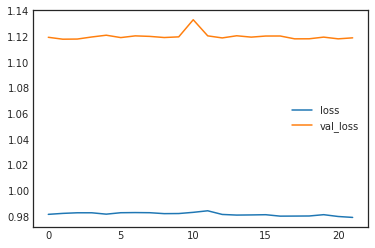

In [26]:
early_stopping20 = EarlyStopping(patience=20)
early_stopping30 = EarlyStopping(patience=30)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam(lr=0.002)
model_ann5_s.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_ann5_s.fit(s_train_X, s_train_y, validation_data=(s_test_X, s_test_y), 
                         batch_size=8192, epochs=50, verbose=2, callbacks=[early_stopping20])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(s_train_y, model_ann5_s.predict(s_train_X)), 
       r2_score(s_test_y, model_ann5_s.predict(s_test_X))])
print(time.time()-time1)

In [10]:
s_train_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.243009,-1.074712,0.990305,-4.326325,-3.363023,-1.616348,-0.101192,-1.090530,0.074331,-1.246267,-0.898679,-1.062922,-1.310861,-0.364439,-0.273374,-2.276979,1.280535,-1.183398,-1.594133,0.358283,-2.035241,0.080993,1.144527,-1.253556,0.578784,-0.263684,1.906464
1,-0.243009,-0.971339,0.990305,-4.326325,-3.363023,-1.616348,-1.486989,-1.091612,0.074331,0.533935,-0.869110,-1.062481,0.506767,-0.226494,-0.273374,-2.374758,1.280535,-1.183398,-1.594133,0.358283,-2.035241,0.080993,-1.312468,-1.213550,0.456332,-0.263684,-0.098645
2,-0.243009,-1.057003,0.990305,-4.326325,-3.363023,-1.616348,-1.826523,-0.896354,0.074331,1.130247,-0.644257,-1.062628,1.527008,-0.266564,-0.273374,-2.500734,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,1.369124,-1.223882,0.481324,-0.263684,-2.433507
3,-0.243009,-1.102543,0.990305,-4.326325,-3.363023,-1.616348,-0.099809,-1.191436,0.074331,-1.246267,-1.437214,-1.062334,-1.311134,-0.526218,-0.273374,-2.500734,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,0.947485,-0.650079,0.152906,-0.263684,-0.100045
4,-0.243009,-0.985617,0.990305,-4.326325,-3.363023,-1.616348,2.204548,-1.192405,0.074331,1.631517,-1.016956,3.831617,1.718698,-0.121037,-0.273374,-2.374758,1.280535,-1.183398,-1.594133,0.358283,-2.215931,0.080993,-1.312468,-0.716609,0.107574,-0.263684,-0.097246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257574,-0.090733,0.518169,-2.302581,-0.713413,-1.111884,0.339176,-0.967385,-0.081830,-3.171429,-0.335738,1.243210,-0.462838,-0.190681,-0.353712,-0.570340,2.655980,-1.680829,-0.604873,-1.208066,4.040666,2.747210,-3.140100,-0.039642,0.442993,-0.607330,-0.613075,-0.800385
1257575,-0.138680,0.310771,-2.302581,-0.713413,-1.111884,0.339176,0.017790,-0.500201,-3.176602,0.834343,1.281042,1.318033,0.224715,-0.202460,-0.583245,2.661122,-1.680829,-0.604873,-1.208066,4.040666,2.789784,-3.158960,-0.364575,0.468002,-0.573493,-0.615193,0.637974
1257576,-0.118931,0.335742,-2.302581,-0.713413,-1.111884,0.339176,-0.908813,-0.413949,-3.174678,0.746594,1.223230,0.182645,0.535030,-0.104845,-0.582832,2.606503,-1.680829,-0.604873,-1.208066,4.040666,2.773864,-3.192468,-0.417016,0.788133,-0.563579,-0.615193,-0.354678
1257577,-0.030183,0.659125,-2.302581,-0.713413,-1.111884,0.339176,1.828903,-0.575448,-3.160503,1.102001,1.028767,1.488074,0.692212,0.097405,-0.577758,2.712985,-1.680829,-0.604873,-1.208066,4.040666,2.761317,-3.228561,-0.435491,0.804901,-0.562638,-0.615193,-0.259998


In [ ]:
import pickle

with open("ann_s", "wb") as fp:   #Pickling
    pickle.dump(ann_results, fp)

In [ ]:
temp = pd.DataFrame(ann_results)
temp.to_csv('ann_results_2.csv')

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
create_download_link(temp)
